In [34]:
import pyAudioKits.audio as ak
import pyAudioKits.analyse as aly
import pyAudioKits.filters as flt
import pyAudioKits.algorithm as alg

This section describes how to filter noise from speech signals to enhance speech signals. Note that the "noise" here is different from the noise in the physical sense we defined before. It refers to the audio component that does not contain useful speech information, which is usually superimposed with the speech signal in the time domain. The noise will mask the speech components and degrade the quality of the speech signal. It will be difficult for human ears to distinguish speech, and the features extracted by machines from speech will also be disturbed.

If the noise superimposed in the time domain and speech can be separated from the speech signal after being converted to the frequency domain, the noise can be removed by using the LTI filter introduced in Section 5. However, if the noise still overlaps with the speech signal in the frequency domain, the use of LTI filter to filter the noise will inevitably lead to the serious loss of specific frequency components of the speech signal at the same time.

White noise is a common noise. The current noise generated during audio recording belongs to white noise. First read the sample audio from "sample_audio/test.wav".

In [12]:
s = ak.read_Audio("sample_audio/test.wav")
s.sound()

The power of the audio:  0.0007003224173257517


Then add white noise with a signal-to-noise ratio of 10dB on the example audio.

In [13]:
f = s.addWgn(10)
f.sound()

The power of the audio:  0.0007687051202801418


White noise interference can be heard in the background at this time. It is also reflected on the waveform. 

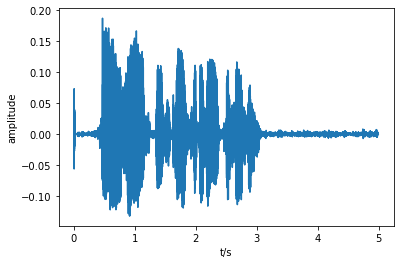

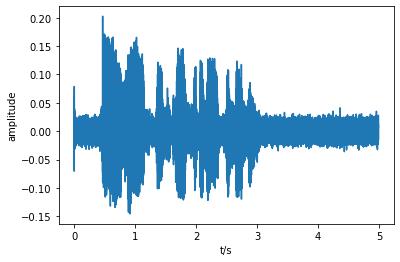

(None, None)

<Figure size 432x288 with 0 Axes>

In [14]:
s.plot(), f.plot()

Draw the spectrogram before and after adding the noise.

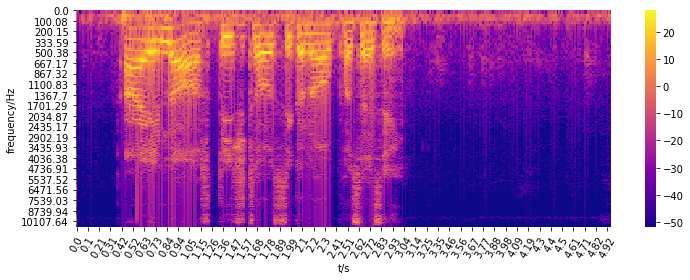

<Figure size 432x288 with 0 Axes>

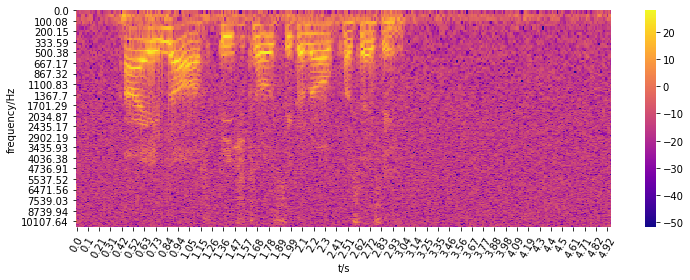

(None, None)

<Figure size 432x288 with 0 Axes>

In [15]:
aly.FFT(s.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB")

The frequency of white noise is distributed in the whole frequency range, and it cannot be separated from speech signal in the frequency domain. In this case, no matter how to design the passband stopband characteristics of the LTI filter, it can not guarantee to filter white noise while maintaining the speech signal components as much as possible. We must use other filtering methods. This section will introduce three filtering methods: spectral subtraction, Wiener filter and Kalman filter.

# Spectral subtraction

The idea of spectral subtraction is very simple: if you know the spectrum of the noisy signal and the spectrum of the noise, then subtract the spectrum of the noise from the spectrum of the noisy signal to obtain the spectrum of the original signal. This method is applicable to **additive noise**, that is, noise and speech signal are linearly added. Because Fourier transform is a linear transform, the spectrum of noise and speech signals linearly added in time domain is also linearly added.

When performing spectral subtraction, we need to get **noise estimation** first. The steps of spectral subtraction are as follows:

1. Set a parameter $\beta$, usually 0.002.
2. Perform framing and windowing on noisy speech and noise estimation.
3. Perform Fourier transform in each frame.
4. Calculate the inter frame mean value of the amplitude spectrum of each frame in noise estimation $|\hat D[k]|$
5. Save the phase spectrum $\angle X[k]$of each frame in noisy speech.
6. Calculate the amplitude spectrum $|X[k]|$ of each frame in noisy speech.
7. Use the results in 4 and 6 to calculate the signal-to-noise ratio of each frame in the speech.
8. For each frame in the speech, we have $\alpha=\begin{cases}4-3*SNR/20,&SNR\in[-5,20]\\5,&SNR\in(-∞,-5)\\1&SNR\in (20,+∞)\end{cases}$
9. Calculate $|\hat X[k]|^2=\begin{cases}|X[k]|^2-\alpha|\hat D[k]|^2,& |X[k]|^2>(\alpha+\beta)|\hat D[k]|^2\\\beta|\hat D[k]|^2,& others\end{cases}$
10. Calculate$\sqrt{|\hat X[k]|^2}$. Recover the phase using the results in 5. 

Since we use the same noise estimation to perform spectral subtraction for each frame of noisy speech, it is not difficult to see that the premise of using spectral subtraction is that the noise statistical characteristics of each frame are the same. Therefore, spectral subtraction requires that the noise must satisfy a stationary stochastic process. White noise satisfies a stationary stochastic process, so spectral subtraction can be used to filter it out.

There is no speech in the last few seconds of our noisy speech, only noise, so we take the last 0.3 seconds of the noisy speech as the noise estimate.

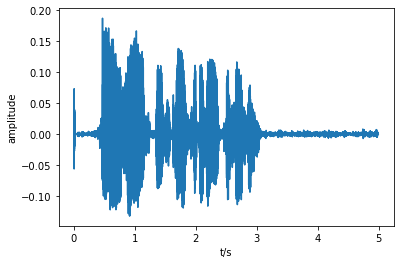

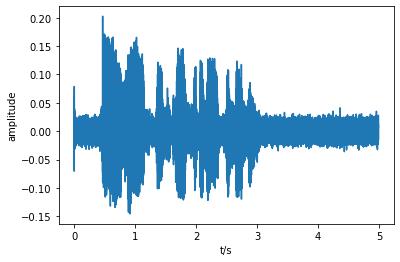

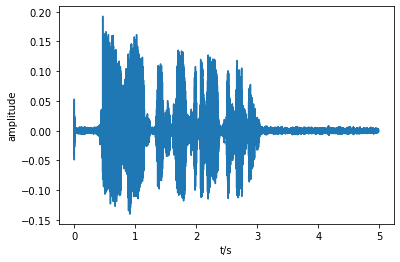

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [16]:
f1=alg.specSubstract(f,f[f.getDuration()-0.3:])
s.plot(), f.plot(), f1.plot()   #依次绘制原始信号、加噪信号和谱减法结果的波形图

From the waveform, spectral subtraction has greatly removed the intensity of noise, while preserving the intensity of speech as much as possible.

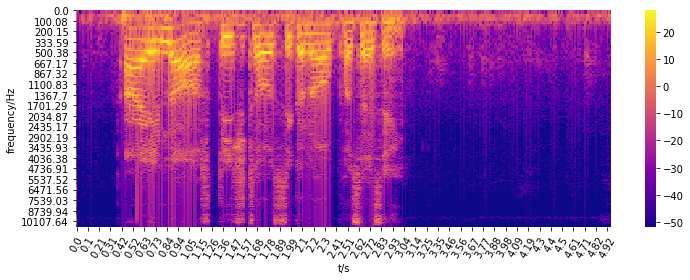

<Figure size 432x288 with 0 Axes>

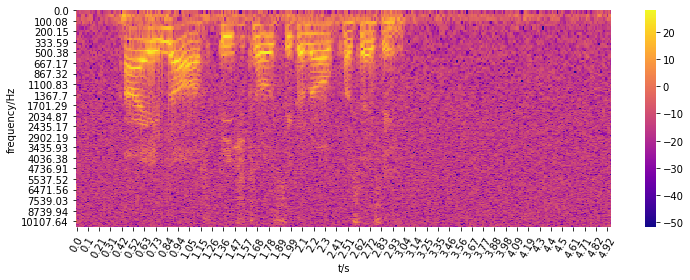

<Figure size 432x288 with 0 Axes>

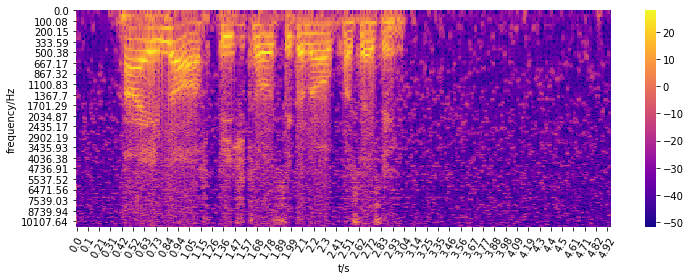

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [17]:
aly.FFT(s.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f1.framing()).plot(freq_scale="mel", plot_type="dB")   #Draw the spectrogram of original speech, noisy speech and spectral subtraction results in turn

From the spectrogram, the white noise in the full frequency range has been eliminated to a certain extent, but there are still granular residues in the full frequency range.

# Wiener filtering

Wiener filtering is a theoretically optimal filtering method, which makes use of the statistical characteristics of stationary random processes.

A signal with additive background noise $x=s+v$ is known and the goal is to solve for $h=\displaystyle\min_hE\{e^2\}=\min_hE\{(s-x*h)^2\}=\min_hE\{(s[n]-\sum_{m}x[n-m]h[m])^2\}$ where $h$ is the unit impulse response of the Wiener filter system, $y=h*x$. 

Taking partial derivatives of $h[j]$ yields $\displaystyle\frac{\partial e^2}{\partial h[j]}=2E\{(\sum_{m}x[n-m]h[m]-s[n])x[n-j]\}=2E\{\sum_{m}h[m]x[n-m]x[n-j]-s[n]x[n-j]\}$. 

Framing and windowing the original signal. The frame length should not be too long to ensure stationarity of $x[n]$ and $s[n]$ within a frame; nor should it be too short to ensure that the statistical properties of each ergodic process can be estimated using the information of $x[n]$ and $s[n]$ within the frame. This allows rewriting the above equation as follows: 


$\begin{aligned}\displaystyle2E\{\sum_{m}h[m]x[n-m]x[n-j]-s[n]x[n-j]\}&=2\sum_{m=0}^Nh[m]x[n-m]x[n-j]-\sum_{n=}s[n]x[n -j]\\&=2\sum_{m=0}^N h[m]R_{xx}[n-m]-2R_{xs}[n]\end{aligned}$

Let the derivative be 0 to get $\displaystyle R_{xs}[n]=\sum_mh[m]R_{xx}[n-m],n≥0$. 

In this way, we can get the equation satisfied by FIR filter $h$: $R_{xs}[n]=\displaystyle\sum_{m=0}^{N-1}h[m]R_{xx}[n-m]$. As long as we know the values of N points in $R_{xs}$ and $R_{xx}$, n values of $h(m)$ can be calculated by linear algebra, so as to obtain n-order FIR filter $h$. In practical application, it is difficult to solve it directly by matrix inversion, but Levinson Durbin iterative algorithm can be used to solve it.

In order to solve for $h$, we need to know $R_{xs}$ and $R_{xx}$, which is computed by estimating the original signal $s$. 

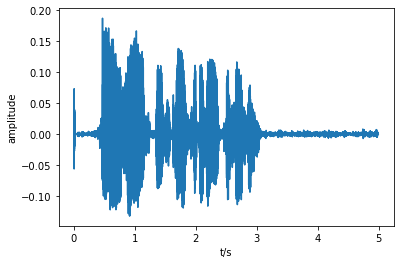

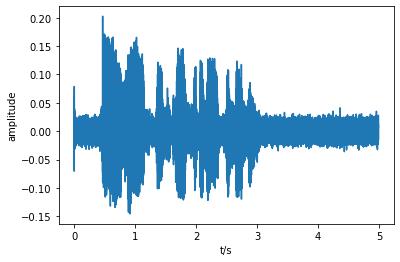

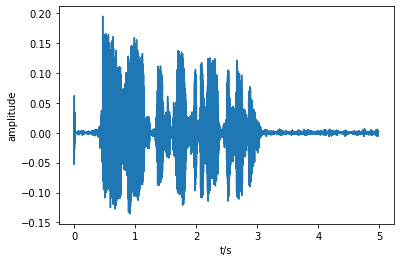

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [18]:
f2=alg.wienerFilter(f,s)
s.plot(), f.plot(), f2.plot()   #Draw the waveform of the original signal, the noisy signal and the Wiener filtering result in turn

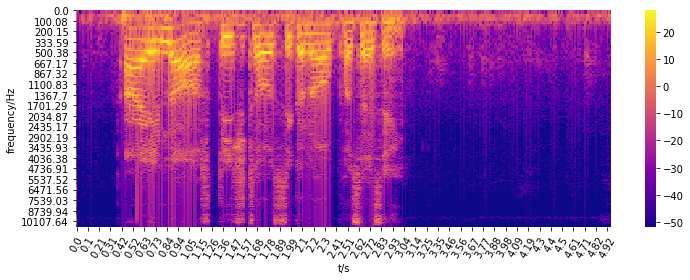

<Figure size 432x288 with 0 Axes>

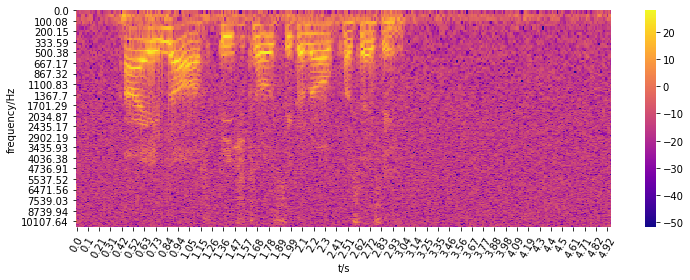

<Figure size 432x288 with 0 Axes>

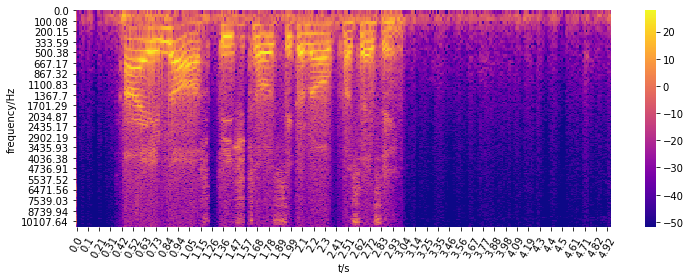

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [19]:
aly.FFT(s.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f2.framing()).plot(freq_scale="mel", plot_type="dB")   #Draw the spectrogram of original speech, noisy speech and Wiener filtering results in turn

It can be seen from the waveform and spectrogram that the effect of Wiener filtering is very good. Its disadvantage is that it requires the estimation of the original speech signal.

# Kalman filtering

Before understanding Kalman filtering, it is necessary to understand the **Markov hypothesis**: with a stochastic process $\{X_t,t=0,1,... \}$ satisfies $P(X_t|X_{0:t-1})=P(X_t|X_{t-1})$, where $P(X_t)$ is the probability distribution of the stochastic process $X$ at time $t$, and $X_{0:t-1}$ denotes $\{X_0,... ,X_{t-1}\}$. Here, time is discretized into moments. The probability distribution of the stochastic process $\{X_t\}$ is not time-independent, but also not dependent between any moments. The significance of $P(X_t|X_{0:t-1})=P(X_t|X_{t-1})$ is that the probability distribution of $\{X_t\}$ at $t$ moments is only affected by the value of $X$ at $t-1$ moments. We call $P(X_t|X_{t-1})$ a **transfer model** that satisfies Markov's assumption.

Suppose $\{X_t,t=0,2,... \}$ are **hidden state variables**, we have no way to observe the values of these variables directly. But we can observe the values of another set of variables $\{E_t,t=0,1,... \}$, and this set of variables is called the **evidence variables**. The evidence variables constitute another stochastic process and are probabilistically non-independent between $\{X_t\}$ with $P(E_t|X_{1:t},E_{1:t-1})=P(E_t|X_t)$, where $E_{0:t-1}$ denotes $\{E_0,... ,E_{t-1}\}$. Then $P(E_t|X_t)$ is said to be the **emission model**.

The Kalman filter is based on the Markov assumption. Let all random variables be continuous variables, then we have $P(x_{t+1}|e_{0:t})=\displaystyle\int_{x_t}P(x_{t+1}|x_t)P(x_t|e_{0:t})dx_t$. It also assumes that all probability distributions are normal and are multidimensional if $\{x_t\}$ and $\{e_t\}$ are multidimensional random variables $\{\vec x_t\}$, $\{\vec e_t\}$. Let the mean vector of the multidimensional normal distribution satisfied by $\{\vec x_t\}$ at each moment be $\{\vec\mu_t,t=0,1,... \}$, the covariance matrix is $\{\Sigma_t,t=0,1,... \}$, then the Kalman filter models the relationship between the variables in this way: 

* Initial state: $P(\vec{x_0})=\alpha e^{-\frac{1}{2}(\vec{x_0}-\vec{\mu_0})^T\Sigma_0^{-1}(\vec{x_0}-\vec{\mu_0})}$
* Transfer equation: $\vec{x_{t+1}}=F\vec{x_t}+\vec{s_t}$, $F$ is the matrix of non-independent transfer relations between dimensions, $\vec{s_t}$ is Gaussian noise with mean 0 vector, and the covariance matrix is $\Sigma_x$
* Transfer model: $P(\vec{x_{t+1}}|\vec{x_t})=\alpha e^{-\frac{1}{2}(\vec{x_{t+1}}-F\vec{x_t})^T\Sigma_x^{-1}(\vec{x_{t+1}}-F\vec{x_t})}$
* Emission equation: $\vec{e_{t}}=H\vec{x_t}+\vec{v_t}$, $H$ is the matrix of non-independent transfer relations between dimensions, $\vec{v_t}$ is Gaussian noise with mean 0 vector, and the covariance matrix is $\Sigma_e$
* Emission model: $P(\vec{e_{t}}|\vec{x_t})=\alpha e^{-\frac{1}{2}(\vec{e_{t}}-H\vec{x_t})^T\Sigma_e^{-1}(\vec{e_{t}}-H\vec{x_t})}$

At this point, the mean vector and covariance matrix of $\{\vec x_t\}$ at any moment can be solved recursively by the following equation: 

* $\begin{cases}\vec{\mu_{t+1}}=F\vec{\mu_t}+K_{t+1}(\vec{e_{t+1}}-HF\vec{\mu_t})\\\Sigma_{t+1}=(I-K_{t+1}H)(F\Sigma_tF^T+\Sigma_x)\end{cases}$

* Where $K_{t+1}=(F\Sigma_tF^T+\Sigma_x)H^T(H(F\Sigma_tF^T+\Sigma_x)H^T+\Sigma_e)^{-1}$, called the **Kalman gain matrix**

So, how can we apply the model of Kalman filtering to the speech enhancement problem? We observe the noisy signal, while we want to estimate the original signal. That is, we can think of the samples in noisy signal as the **evidence variables** and the samples in original signal as the **hidden state variables**. If the noise is additive Gaussian noise, the emission equation is $\vec{y_n}=H\vec{x_n}+\vec{v_n}$, where $H=[0,0,... ,1]$, $\vec x_n$, $\vec v_n$ and $\vec y_n$ are vector representations of the original signal $x[n]$, the noisy $v[n]$ and the noisy signal $y[n]$, respectively, whose lengths we first assume to be arbitrary. And to obtain the transfer equations, Kalman filtering considers the system in the articulatory model: if the effect of the lips is neglected, the glottis and the vocal tract can be modeled as an all-pole system with the system function $H(z)=\frac{\displaystyle G}{\displaystyle 1-\sum_{m=1}^{p}z^{-m}}$. The airflow $w[n]$ that excites the system approximates the Gaussian white noise signal, so there is the generated speech $x[n]=\displaystyle\sum_{m=1}^{p}a[m]x[n-m]+Gw[n]$, then there is the transfer equation $\vec{x_n}=F\vec{x_{n-1}}+G\vec{w_n}$ , where $\vec{x_n}=[x[n-p+1],x[n-p+2],... ,x[n]]^T$ and $F=\left[\begin{matrix}0&1&...&0\\\vdots&\vdots&\vdots&\vdots\\0&0&...&1\\a[p]&a[p-1]&...&a[1]\end{matrix}\right]$. Thus for a Kalman filter of order p, $\vec x_n$, $\vec v_n$ and $\vec y_n$ are of length p.

To compute $a$, we need to use a technique called linear predictive coding (LPC), which is essentially the computation of the coefficients of a p-order autoregressive (AR) model. There are a variety of parameter estimation methods for autoregressive models. The method used for LPC is the Levinson recursive method.

The premise of applying the autoregressive model is that $x[n]$ must be a single realization of a stationary stochastic process, but speech signals are often not stationary. To do this, we need to perform framing and windowing first. Then the LPC coefficients can be used instead of $a$ within each frame, and the output error $e$ is an estimate of the white noise $Gw[n]$. 

$\Sigma_x$ is a $p\times p$ diagonal array with elements on the diagonal all with e. $\Sigma_e$ is obtained by computing the covariance of the noise estimate.

Finally, we set the initial state $\vec{\mu_0}=[y[0],y[1],... ,y[p-1]]^T$, and $\Sigma_0$ be a $p\times p$ diagonal array with all elements on the diagonal with noise variance, so that iterative estimation of $\vec{\mu_n}$ can be performed. $\vec{\mu_n}$ is the mean of $\vec x_n$, and $\vec{x_n}=[x[n-p+1],x[n-p+2],... ,x[n]]^T$, which means we can use $\vec{\mu_n}$ to estimate $x[m],m=n-p+1,n-p+2,... ,n$. Note that the signals $x[n]$ corresponding to $\vec{\mu_n}$ and $\vec{\mu_{n+1}}$ have overlapping parts, when the estimate of $\vec{\mu_{n+1}}$ is used to override the estimate using $\vec{\mu_n}$.

Estimated should be done in frames: 

1. The $x[n]$ within the kth frame is first estimated.
2. Repeat step 1 4-6 times or more, called the iterating times. Use the new estimate to overwrite the old one.
3. The last p $x[n]$ in the kth frame is kept as $\vec{\mu_0}$ in the k+1th frame.

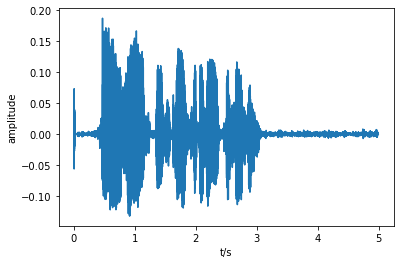

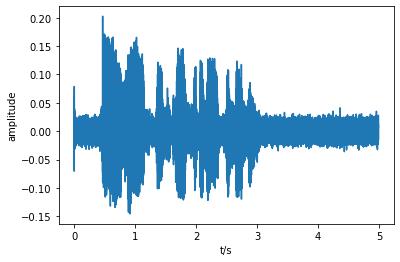

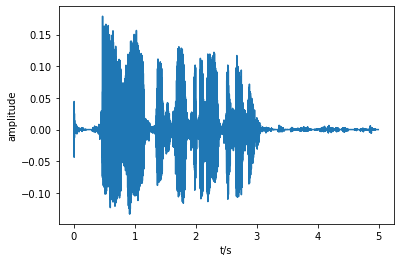

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [20]:
f3=alg.kalmanFilter(f,f[f.getDuration()-0.3:])
s.plot(), f.plot(), f3.plot()   #Plot the waveforms of the original signal, the noise-added signal and the Kalman filter result in turn

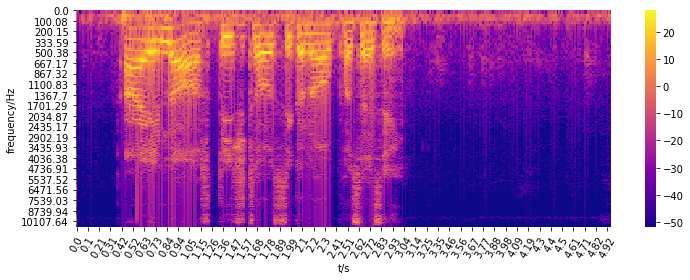

<Figure size 432x288 with 0 Axes>

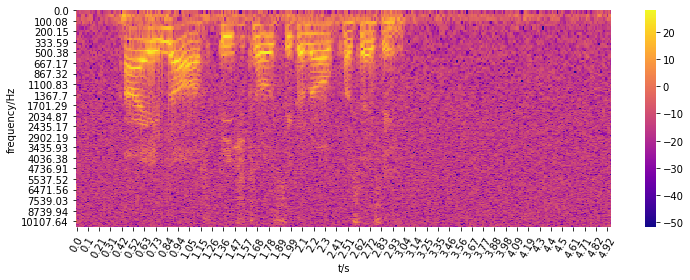

<Figure size 432x288 with 0 Axes>

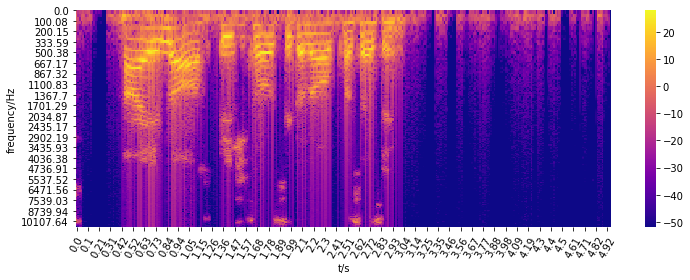

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [21]:
aly.FFT(s.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f3.framing()).plot(freq_scale="mel", plot_type="dB")   #依次绘制原始语音、带噪语音和卡尔曼滤波结果的语谱图

Kalman filtering works very well for Gaussian white noise because Gaussian white noise fits the assumptions made when modeling Kalman filtering.

Next, we import another noise sample from the example audio. This noise data is from: https://www.kaggle.com/datasets/bharatsahu/speech-commands-classification-dataset

In [22]:
noise=ak.read_Audio("sample_audio/_background_noise_/exercise_bike.wav")

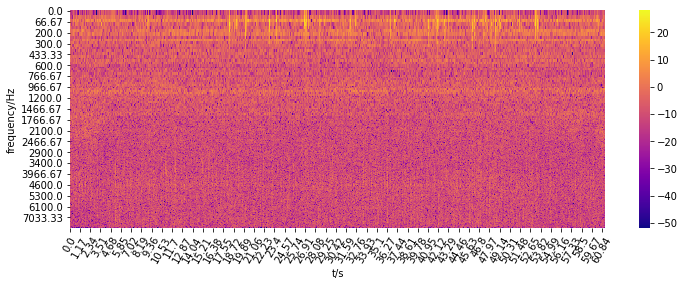

<Figure size 432x288 with 0 Axes>

In [23]:
aly.FFT(noise.framing()).plot(freq_scale="mel", plot_type="dB")

The frequency component of the noise is distributed over [0,sampling rate/2] and is slightly larger in the low frequency part.

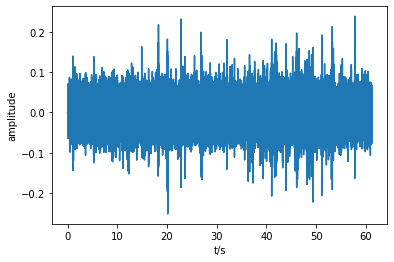

<Figure size 432x288 with 0 Axes>

In [24]:
noise.plot()

In [26]:
noise.getDuration(), noise.sr, s.getDuration(), s.sr

(61.253875, 16000, 4.992290249433107, 22050)

The duration of the noise sample is longer than the sample audio duration, and the sampling rate is only 16000Hz, which is less than the sample audio sampling rate of 22050Hz. Therefore we need to slice the noise sample to match the duration of the sample audio, and **resample** it.

In [27]:
noise = noise.resample(s.sr)
noise.sr

/Users/harmonialeo/Documents/source/pyAudioKits/pyAudioKits/audio/audio.py:108: FutureWarning: Pass orig_sr=16000, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return Audio(librosa.resample(self.samples,self.sr,newRate),newRate)


22050

After resampling, the sampling rate of the noise sample is also 22050 Hz. We take the first 5 seconds to match the sample audio duration and then mix it with the sample audio at a 5 dB signal-to-noise ratio.

In [28]:
snr=5
f = ak.mixWithSNR(s,noise[0:s.getDuration()],snr,maintain="signal")

In [29]:
f.sound()

The power of the audio:  0.0009298321119574613


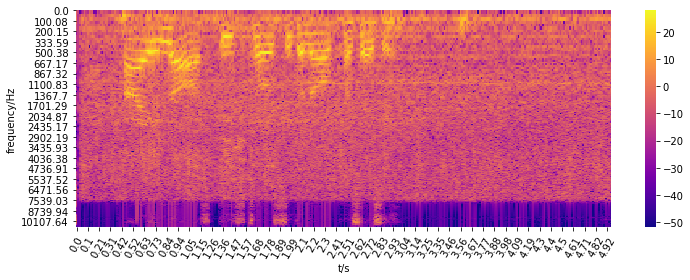

<Figure size 432x288 with 0 Axes>

In [30]:
aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB")

The frequency components of the resampled noise signal are still distributed on [0,8000Hz], where 8000Hz is half of the original sampling rate of 16000Hz, and not expanded to 11025Hz, i.e. half of 22050Hz, with the increase of the sampling rate. This is because the original noise sample using 16000Hz sampling can only retain at most [0,sample rate/2] of the spectral information, and the spectral information above sample rate/2 will be lost and cannot be restored. The sampling rate/2 is called **Nyquist rate**, and reversible sampling satisfies that all frequency components of the sampled signal are smaller than it. Otherwise, the sampling would be non-reversible.

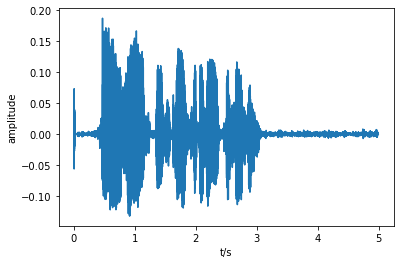

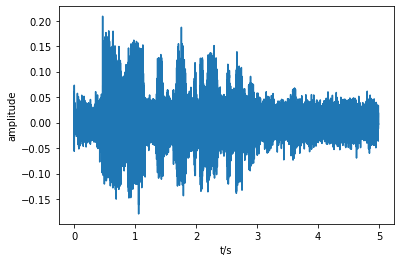

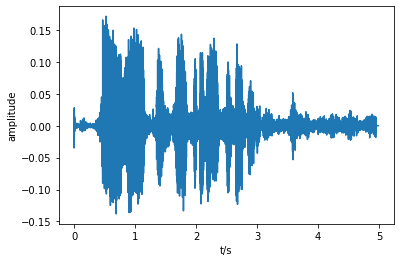

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [32]:
f3=alg.kalmanFilter(f,f[f.getDuration()-0.3:])
s.plot(), f.plot(), f3.plot()

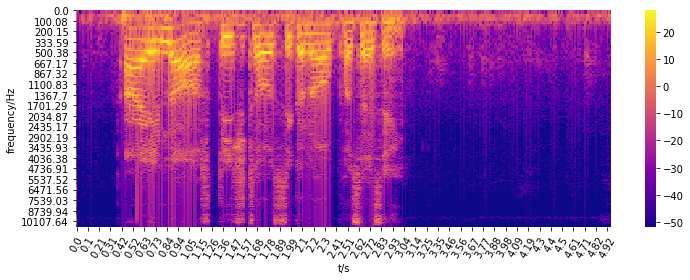

<Figure size 432x288 with 0 Axes>

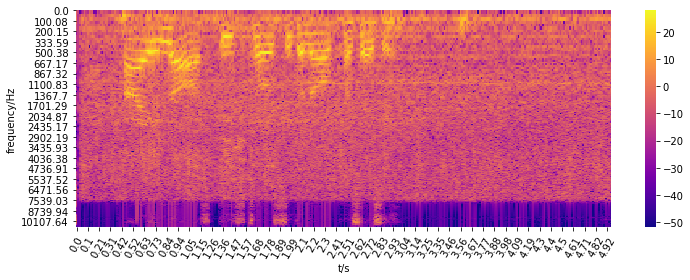

<Figure size 432x288 with 0 Axes>

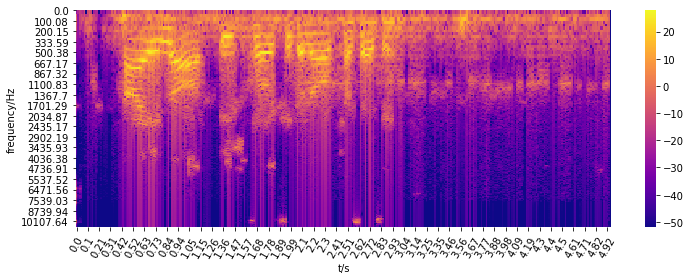

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [33]:
aly.FFT(s.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f.framing()).plot(freq_scale="mel", plot_type="dB"), aly.FFT(f3.framing()).plot(freq_scale="mel", plot_type="dB")

For non-Gaussian white noise, the effectiveness of Kalman filtering is then reduced.